In [3]:
import pandas as pd
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.model_selection import GridSearchCV
import graphviz 
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_text
import graphviz  
from sklearn.tree import export_graphviz

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LinearRegression

import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

In [4]:
# Load data
df = pd.read_csv('ShootingSplits_HeatCheckTour.csv')
df = df.dropna(axis=1)
print(df.shape)
df.head(3)

(704, 47)


,Unnamed: 0,YEAR,TEAM NO,TEAM ID,TEAM,CONF,DUNKS FG%,DUNKS SHARE,DUNKS FG%D,DUNKS D SHARE,...,THREES D SHARE RANK,SEED,ROUND,POWER,PATH,WINS,POOL VALUE,POOL S-RANK,NCAA S-RANK,POWER-PATH
0,0,2024,1079,2,Akron,MAC,97.2,6.8,90.6,5.6,...,170,14,64,54.3,79.8,0,2.0,54,54,-25.5
1,1,2024,1078,3,Alabama,SEC,81.9,9.5,89.2,7.3,...,164,4,4,77.3,66.4,4,39.0,13,16,10.9
2,2,2024,1077,8,Arizona,P12,91.2,11.9,89.3,5.9,...,219,2,16,86.2,64.6,2,91.8,2,6,21.6


In [5]:
# Split into train and test, and drop highly correlated variables, and standardize
df_train = df[df['YEAR'] != 2024]
df_test = df[df['YEAR'] == 2024]
X_train = df_train.drop(['Unnamed: 0','YEAR','TEAM NO','TEAM ID','TEAM','CONF','WINS','ROUND', 'POWER-PATH', 'POWER', 'PATH', 'POOL VALUE', 'POOL S-RANK', 'NCAA S-RANK'],axis=1)
X_test = df_test.drop(['Unnamed: 0','YEAR','TEAM NO','TEAM ID','TEAM','CONF','WINS','ROUND', 'POWER-PATH', 'POWER', 'PATH', 'POOL VALUE', 'POOL S-RANK', 'NCAA S-RANK'],axis=1)
stnd = StandardScaler().set_output(transform = 'pandas')
X_train = stnd.fit_transform(X_train)
X_test = stnd.transform(X_test)
y_train = df_train.WINS
y_test = df_test.WINS

In [6]:
# Only go until 2nd degree features, include squared terms
poly = PolynomialFeatures(2, interaction_only = False, include_bias = False)
Xe_train = poly.fit_transform(X_train)
Xe_train = pd.DataFrame(Xe_train, columns = poly.get_feature_names_out())
Xe_test = poly.fit_transform(X_test)
Xe_test = pd.DataFrame(Xe_test, columns = poly.get_feature_names_out())
Xe_train['bias'] = 1
Xe_test['bias'] = 1

In [58]:
# Straight from HW6
def SelectFeature(model,candidates,Xe_train,y_train):
    lr = LogisticRegression(solver='lbfgs', max_iter=50000)
    R2_valid = []
    for candidate in candidates:
        model.append(candidate)
        R2_valid_scores = cross_validate(lr, Xe_train[model], y_train)['test_score']
        R2_valid.append(R2_valid_scores.mean())
        model.remove(candidate)
    print(len(candidates), max(R2_valid))
    return (candidates[R2_valid.index(max(R2_valid))], max(R2_valid))

In [59]:
model = ['bias']
candidates = list(Xe_train.columns)
candidates.remove('bias')

lr = LogisticRegression(solver='lbfgs', max_iter=50000)
R2_valid_scores = cross_validate(lr, Xe_train[model], y_train)['test_score']
R2 = [R2_valid_scores.mean()]

while (len(candidates)):
    (x,R2_max) = SelectFeature(model,candidates,Xe_train,y_train)
    candidates.remove(x)
    model.append(x)
    R2.append(R2_max)

594 0.5265625
593 0.534375
592 0.5421875
591 0.5484375
590 0.5625
589 0.565625
588 0.571875
587 0.5765625
586 0.578125
585 0.5796875
584 0.578125
583 0.578125
582 0.584375
581 0.5875
580 0.5875
579 0.5890625
578 0.5890625
577 0.5859375
576 0.584375
575 0.5828125
574 0.5859375
573 0.5859375
572 0.5828125
571 0.58125
570 0.5828125
569 0.5796875
568 0.578125
567 0.58125
566 0.5796875
565 0.578125
564 0.5796875
563 0.584375
562 0.5828125
561 0.5828125
560 0.5796875
559 0.575
558 0.5734375
557 0.571875
556 0.571875
555 0.575
554 0.575
553 0.5765625
552 0.5828125
551 0.5796875
550 0.5796875
549 0.5765625


KeyboardInterrupt: 

In [62]:
results = pd.DataFrame()
results['feature added'] = model[:-1]
results['valid R2'] = R2
ix = results['valid R2'].idxmax()
model_opt = model[0:ix+1]
pd.set_option('display.max_rows', 600)
display(results)

,feature added,valid R2
0,bias,0.500000
1,SEED,0.526563
2,DUNKS D SHARE CLOSE TWOS D SHARE RANK,0.534375
3,DUNKS D SHARE THREES FG% RANK,0.542188
4,CLOSE TWOS FG% CLOSE TWOS FG% RANK,0.548438
5,DUNKS FG%D THREES D SHARE RANK,0.562500
6,DUNKS SHARE,0.565625
7,DUNKS FG% THREES SHARE,0.571875
8,DUNKS SHARE FARTHER TWOS FG% RANK,0.576562
9,THREES FG% THREES SHARE RANK,0.578125


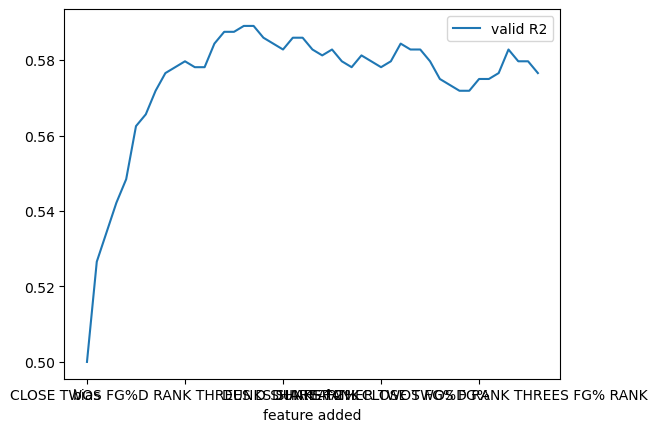

In [63]:
ax1 = results.plot.line(x='feature added',y='valid R2')

In [1]:
model_opt = ['bias',
 'SEED',
 'DUNKS D SHARE CLOSE TWOS D SHARE RANK',
 'DUNKS D SHARE THREES FG% RANK',
 'CLOSE TWOS FG% CLOSE TWOS FG% RANK',
 'DUNKS FG%D THREES D SHARE RANK',
 'DUNKS SHARE',
 'DUNKS FG% THREES SHARE',
 'DUNKS SHARE FARTHER TWOS FG% RANK',
 'THREES FG% THREES SHARE RANK',
 'CLOSE TWOS FG%D RANK THREES D SHARE RANK',
 'FARTHER TWOS FG% FARTHER TWOS SHARE',
 'DUNKS FG% THREES D SHARE RANK',
 'CLOSE TWOS FG%D^2',
 'FARTHER TWOS D SHARE THREES FG%',
 'FARTHER TWOS FG% DUNKS FG% RANK',
 'CLOSE TWOS FG% THREES FG%D RANK']

In [9]:
Xe_train_opt = Xe_train[model_opt]
lr = LogisticRegression(solver='lbfgs', max_iter=50000)
lr.fit(Xe_train_opt, y_train)
train_R2 = lr.score(Xe_train_opt, y_train)
train_R2

0.59375

In [10]:
Xe_test_opt = Xe_test[model_opt]
test_R2 = lr.score(Xe_test_opt, y_test)
test_R2

0.484375

In [13]:
coef_data = pd.DataFrame(index = Xe_train_opt.columns)
intercepts = []
for i in range(7):
    coef_data['coefficients for WINS = ' + str(i)] = lr.coef_[i].reshape(-1, 1)
    intercepts.append(lr.intercept_[i])
coef_data.loc['intercepts'] = intercepts
coef_data

,coefficients for WINS = 0,coefficients for WINS = 1,coefficients for WINS = 2,coefficients for WINS = 3,coefficients for WINS = 4,coefficients for WINS = 5,coefficients for WINS = 6
bias,0.001624,0.001185,0.000268,-0.000146,0.000150,0.000888,-0.003969
SEED,1.733271,0.712339,0.105358,-0.206787,-0.153651,-0.737577,-1.452952
DUNKS D SHARE CLOSE TWOS D SHARE RANK,0.071868,0.045839,-0.187796,0.012967,0.164241,0.137905,-0.245024
DUNKS D SHARE THREES FG% RANK,-0.109487,0.159904,0.074418,0.069750,-0.143898,0.113464,-0.164151
CLOSE TWOS FG% CLOSE TWOS FG% RANK,0.030304,0.199812,-0.156148,-0.217706,0.467142,-0.377076,0.053672
DUNKS FG%D THREES D SHARE RANK,0.273807,0.277376,-0.164502,0.394598,-0.221676,-0.618354,0.058750
DUNKS SHARE,-0.094052,-0.252440,-0.005455,0.169556,-0.015831,-0.058871,0.257093
DUNKS FG% THREES SHARE,0.246930,0.108178,0.273619,-0.030993,-0.450157,0.055245,-0.202822
DUNKS SHARE FARTHER TWOS FG% RANK,-0.152434,-0.144301,0.020949,-0.031282,0.066799,0.072982,0.167287
THREES FG% THREES SHARE RANK,0.081955,0.053788,0.060202,0.045025,-0.009560,-0.009781,-0.221630


In [14]:
coef_data_abs = coef_data.abs()
mean_abs_coef = coef_data_abs.mean(axis=1)
sorted_features = mean_abs_coef.sort_values(ascending=False)
sorted_features

intercepts                                  1.661076
SEED                                        0.728848
DUNKS FG%D THREES D SHARE RANK              0.287009
CLOSE TWOS FG% CLOSE TWOS FG% RANK          0.214551
DUNKS FG% THREES SHARE                      0.195421
DUNKS FG% THREES D SHARE RANK               0.176107
CLOSE TWOS FG%D^2                           0.173644
CLOSE TWOS FG% THREES FG%D RANK             0.172078
FARTHER TWOS FG% DUNKS FG% RANK             0.164256
FARTHER TWOS D SHARE THREES FG%             0.146582
FARTHER TWOS FG% FARTHER TWOS SHARE         0.128380
DUNKS D SHARE CLOSE TWOS D SHARE RANK       0.123663
DUNKS SHARE                                 0.121900
DUNKS D SHARE THREES FG% RANK               0.119296
DUNKS SHARE FARTHER TWOS FG% RANK           0.093719
CLOSE TWOS FG%D RANK THREES D SHARE RANK    0.076986
THREES FG% THREES SHARE RANK                0.068849
bias                                        0.001176
dtype: float64

In [29]:
def PolyFeatures(X,degree,interaction_only=False):
    poly = PolynomialFeatures(degree,interaction_only=interaction_only)
    if X.ndim == 1:
        Xe = poly.fit_transform(X.values.reshape(-1,1))
        cols = poly.get_feature_names_out([X.name])
    else:
        Xe = poly.fit_transform(X)
        cols = poly.get_feature_names_out(X.columns)
    Xe = pd.DataFrame(Xe,columns=cols)
    print('X shape =',X.shape)
    print('X (engineered) shape =',Xe.shape)
    return Xe

In [30]:
Xe_train = PolyFeatures(X_train, degree=2)
Xe_test = PolyFeatures(X_test, degree=2)

X shape = (640, 33)
X (engineered) shape = (640, 595)
X shape = (64, 33)
X (engineered) shape = (64, 595)



best alpha = {'alpha': 1000}   valid R2 = 0.139


SEED                       -0.176453
CLOSE TWOS FG% RANK        -0.067396
CLOSE TWOS FG% SEED        -0.052715
THREES FG%D                -0.043085
DUNKS SHARE RANK           -0.040773
                              ...   
THREES FG%                  0.038593
DUNKS SHARE                 0.043250
SEED^2                      0.048624
CLOSE TWOS FG% RANK SEED    0.051841
CLOSE TWOS FG%              0.067647
Length: 595, dtype: float64

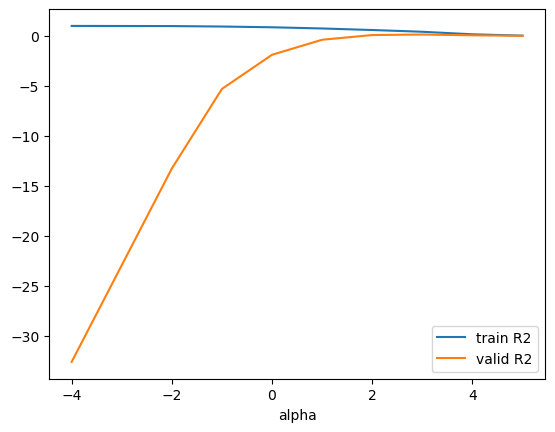

In [32]:
grid = {'alpha':[0.0001,0.01,0.1,1,10,100,1000,10000,100000]} # Use a log (base 10) scale to iterate over hyperparameter values
ridge = Ridge()
ridgeCV = GridSearchCV(ridge,param_grid=grid,return_train_score=True) # Optimize alpha
ridgeCV.fit(Xe_train,y_train) # Fit to training set

print()
print('best alpha =',ridgeCV.best_params_, '  valid R2 =',ridgeCV.best_score_.round(3))

results = pd.DataFrame()
results['alpha'] = np.log10(grid['alpha']) # Plot on a log base 10 grid, x-axis is the exponent
results['train R2'] = ridgeCV.cv_results_['mean_train_score']
results['valid R2']  = ridgeCV.cv_results_['mean_test_score']
ax1 = results.plot.line(x='alpha',y='train R2')
results.plot.line(x='alpha',y='valid R2',ax=ax1)

ridge = ridgeCV.best_estimator_
coef = pd.Series(ridge.coef_,index=Xe_train.columns)
coef.sort_values()

C:\Users\ranadeva\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.443e+01, tolerance: 9.199e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\ranadeva\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.566e+01, tolerance: 9.199e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\ranadeva\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi


best alpha = {'alpha': 0.1}   valid R2 = 0.309


SEED                                     -0.574315
CLOSE TWOS FG% SEED                      -0.117912
THREES FG%D                              -0.017714
CLOSE TWOS D SHARE^2                     -0.014437
DUNKS FG%D THREES D SHARE RANK           -0.007957
                                            ...   
CLOSE TWOS SHARE CLOSE TWOS SHARE RANK    0.000000
DUNKS SHARE^2                             0.000281
DUNKS FG%D FARTHER TWOS D SHARE           0.003839
SEED^2                                    0.070364
CLOSE TWOS FG%                            0.088550
Length: 595, dtype: float64

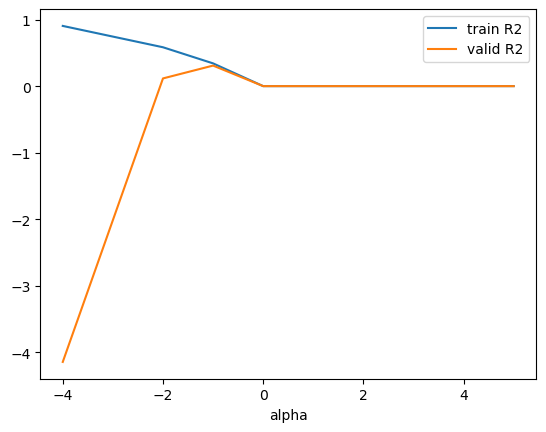

In [34]:
# regularize
grid = {'alpha':[0.0001,0.01,0.1,1,10,100,1000,10000,100000]}
lasso = Lasso()
lassoCV = GridSearchCV(lasso,param_grid=grid,return_train_score=True)
lassoCV.fit(Xe_train,y_train)
print()
print('best alpha =',lassoCV.best_params_, '  valid R2 =',lassoCV.best_score_.round(3))

results = pd.DataFrame()
results['alpha'] = np.log10(grid['alpha'])
results['train R2'] = lassoCV.cv_results_['mean_train_score']
results['valid R2']  = lassoCV.cv_results_['mean_test_score']
ax1 = results.plot.line(x='alpha',y='train R2')
results.plot.line(x='alpha',y='valid R2',ax=ax1)

lasso = lassoCV.best_estimator_
coef = pd.Series(lasso.coef_,index=Xe_train.columns)
coef.sort_values()

(-0.1, 0.1)

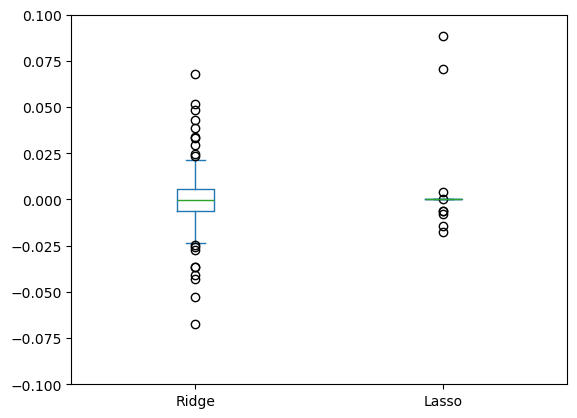

In [35]:
ridge = ridgeCV.best_estimator_
lasso = lassoCV.best_estimator_
coef = pd.DataFrame()
coef['Ridge'] = ridge.coef_
coef['Lasso'] = lasso.coef_
coef.plot.box()
plt.ylim(-0.1,0.1)